In [1]:
import sys, os
import pandas as pd
import numpy as np
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

from random import shuffle
import torch
import torch.nn as nn
from Data_Preprocessing.Graph_Data import Molecule_data
from torch_geometric.loader import DataLoader
from models.AttentiveFPModel import AttentiveFP

In [2]:
if torch.cuda.is_available():  
    device = "cuda:3"
    print("cuda:3")
else:  
    device = "cpu" 
    print(torch.cuda.is_available())

cuda:3


In [3]:
def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    #print('Make prediction for {} samples...'.format(len(loader1.dataset)))
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data.x.float(), data.edge_index,data.batch)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(),total_preds.numpy().flatten()

In [4]:
TRAIN_BATCH_SIZE = 17
processed_data_file_test1 = 'data/processed/' + 'test_data_set_fold_'+str(1)+'.pt'
processed_data_file_train1 = 'data/processed/' + 'train_data_set_fold_'+str(1)+'.pt'
processed_data_file_test2 = 'data/processed/'  + 'test_data_set_fold_'+str(2)+'.pt'

if ((not os.path.isfile(processed_data_file_test1)) or (not os.path.isfile(processed_data_file_test2))):
        print('please run create_data.py to prepare data in pytorch format!')

In [5]:
test_data1 = Molecule_data(root='data', dataset='test_data_set_fold_'+str(1),y=None,smile_graph=None,smiles=None)
test_data2 = Molecule_data(root='data', dataset='test_data_set_fold_'+str(2),y=None,smile_graph=None,smiles=None)

test1_loder   = DataLoader(test_data1,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
test2_loder  = DataLoader(test_data2,batch_size=TRAIN_BATCH_SIZE,shuffle=True)

In [6]:
next(iter(test1_loder))

Batch(x=[369, 114], edge_index=[2, 768], y=[17], c_size=[17], batch=[369], ptr=[18])

In [7]:
model = AttentiveFP(in_channels=114, hidden_channels=292, out_channels=1,
                    num_layers=3, num_timesteps=2,
                    dropout=0.047352327938708194).to(device)

In [8]:
model = model.to(device)

In [9]:
model_file_name = 'saved_models/model_' +  str(1) +  '.model'
model.load_state_dict(torch.load(model_file_name))
test_G,test_P = predicting(model, device, test1_loder)

In [10]:
print(test_G.shape,test_P.shape )

(2086,) (2086,)


In [11]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import math

In [12]:
print(mean_absolute_error(test_G,test_P))

0.2502603


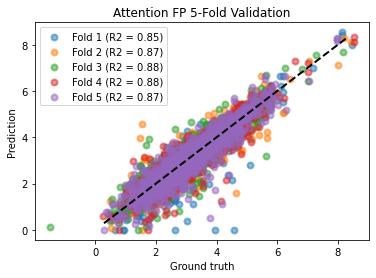

In [13]:
from sklearn import model_selection, preprocessing, metrics, decomposition
import matplotlib.pyplot as plt
scores = []
true_val = []
pred_val = []
fig = plt.figure()
i = 1
for fold in range (5):
   
    test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    
    TRAIN_BATCH_SIZE = 17
    test_loder  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    
    model = AttentiveFP(in_channels=114, hidden_channels=292, out_channels=1,
                    num_layers=3, num_timesteps=2,
                    dropout=0.047352327938708194).to(device)
    
    model = model.to(device)
    model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
    
    model.load_state_dict(torch.load(model_file_name))
    true,prediction = predicting(model, device, test_loder)
    true_val.append(true)
    pred_val.append(prediction)
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    
    plt.scatter(prediction, true, lw=2, alpha=0.5, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(prediction),max(true)], [min(prediction),max(true)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.title('Attention FP 5-Fold Validation')
plt.legend()
plt.grid(False)
plt.savefig('5FoldsR2.png', dpi=400,transparent=True)
plt.show()


# With MAE

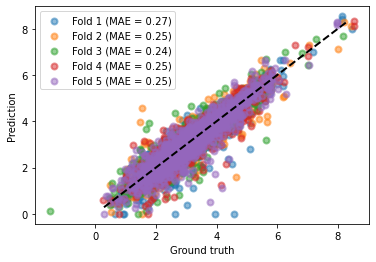

In [14]:
scores = []
true_val = []
pred_val = []
fig = plt.figure()
i = 1
for fold in range (5):
   
    test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    
    TRAIN_BATCH_SIZE = 17
    test_loder  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    
    model = AttentiveFP(in_channels=114, hidden_channels=292, out_channels=1,
                    num_layers=3, num_timesteps=2,
                    dropout=0.047352327938708194).to(device)
    
    model = model.to(device)
    model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
    
    model.load_state_dict(torch.load(model_file_name))
    true,prediction = predicting(model, device, test_loder)
    true_val.append(true)
    pred_val.append(prediction)
    score = mean_absolute_error(true,prediction)
    scores.append(score)
    
    plt.scatter(prediction, true, lw=2, alpha=0.5, 
                label='Fold %d (MAE = %0.2f)' % (i,score))
    i = i+1

plt.plot([min(prediction),max(true)], [min(prediction),max(true)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.legend()
plt.legend()
plt.grid(False)
plt.savefig('5Folds.png', dpi=400,transparent=True)
plt.show()


In [15]:
mae=[]
R_rmse=[]
for i in range(5):
    Mmae = mean_absolute_error(true_val[i],pred_val[i])
    MSE = mean_squared_error(true_val[i], pred_val[i])
    RMSE = math.sqrt(MSE)
    mae.append(Mmae)
    R_rmse.append(RMSE)
    
avg_mae = sum(mae)/5
avg_rmse = sum(R_rmse)/5

print(avg_mae,avg_rmse)

0.2528425395488739 0.3605572388258419


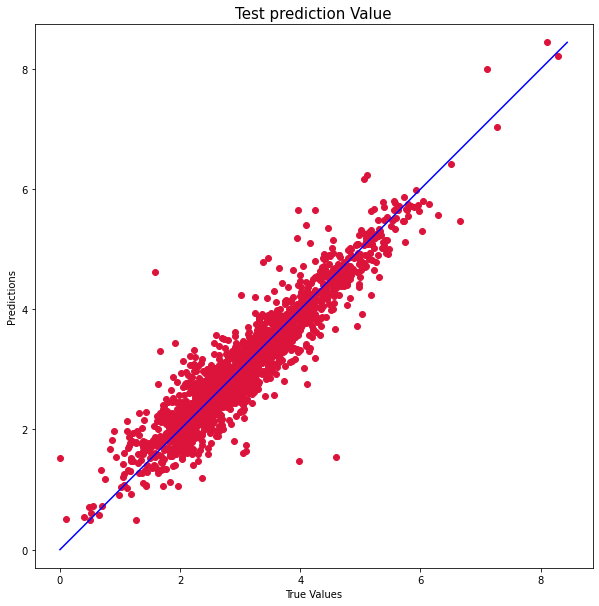

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(test_G, test_P, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(test_P), max(test_G))
p2 = min(min(test_P), min(test_G))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Test prediction Value', fontsize=15)
plt.xlabel('True Values', fontsize=10)
plt.ylabel('Predictions', fontsize=10)
plt.axis('equal')
plt.show()